In [11]:
%reload_ext autoreload
%autoreload 2


import numpy as np
import random
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from pykalman import KalmanFilter
from pypots.imputation import CSDI
from pypots.optim import Adam
from properscoring import crps_ensemble
from sktime.performance_metrics.forecasting.probabilistic import CRPS
import seaborn as sns
import iisignature
import copy

/home/pavel/Anomalies_detection/python3.7.17_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def generate_noise(n_samples, n_steps, noise_rate = 1):
    X = np.zeros((n_samples, n_steps, 1))
    for t in range(0, n_steps):
        X[:, t, 0] = np.random.normal(size = n_samples)
    return X

In [65]:
def generate_ou_process(n_samples, n_steps, mu=0, theta=0.15, sigma=0.3):
    dt = 1.0
    X = np.zeros((n_samples, n_steps, 1))
    X[:,0,0] = mu
    for t in range(1, n_steps):
        dX = theta * (mu - X[:, t-1, 0]) * dt +sigma * np.random.normal(size=n_samples) * np.sqrt(dt)
        X[:, t, 0] = X[:, t-1,0] + dX
    return X

In [3]:
def inject_ou_anomaly(X, start, end, mu=0, theta=0.15, sigma=0.3):
    dt = 1.0
    if (start == 0) :
        X[:,0,0] = mu
        start += 1
    else :
        mu = X[:, start - 1, 0]
    for t in range(start, end + 1) :            
        dX = theta * (mu - X[:, t-1, 0]) * dt + sigma * np.random.normal(size=len(X)) * np.sqrt(dt)
        X[:, t, 0] = X[:, t-1,0] + dX

In [63]:
def inject_sin_anomaly(X, start, end, periods=1, noise_rate=1, sin_ampl = 0.5):
    dt = periods * 2 * np.pi / (end - start + 1) 
    
    if start == 0:
        X[:,0,0] = 0
        start += 1
    for t in range(start, end + 1):
        X[:, t, 0] = sin_ampl * np.sin((t - start + 1) * dt) + np.random.normal(size=len(X)) * noise_rate

In [15]:
def introduce_missigness(X, missing_rate=15, missing_start = -1):
    num_samples, n_steps, n_features = X.shape
    X_missing = copy.deepcopy(X)
    for i in range(num_samples):
        if (missing_start == -1) :
            missing_start = random.randint(0, n_steps - missing_rate)
        X_missing[i, missing_start: missing_start + missing_rate, :] = np.nan
    return X_missing

In [6]:
def sig_data(X, sig_level = 7) :
    (n_samples, n_steps, n_features) = X.shape
    assert(n_features == 1)
    sig_length = iisignature.siglength(n_features + 1, sig_level)
    timeline = np.arange(0, 100, 1)
    Y = np.zeros((n_samples, sig_length))
    for i in range(n_samples):
        Y[i] = iisignature.sig(np.column_stack((normalize_arr(timeline), X[i, :, 0])), sig_level)
    return Y
        

In [5]:
def normalize_arr(arr):
    arr = np.array(arr, dtype=float)
    mean = np.mean(arr)
    std_dev = np.std(arr)

    return (arr - mean) / std_dev

In [7]:
def MAE(x, y) :
    assert(len(x) == len(y))
    
    sum = 0
    for i in range(len(x)) :
        sum += abs(x[i] - y[i])
    sum /= len(x)
    return sum

In [8]:
def Loss(real, predicted):
    (n_sampling_times, n_steps) = predicted.shape
    loss = 0
    for i in range(n_sampling_times):
        loss += MAE(predicted[i], real)

    return loss / n_sampling_times

In [69]:
n_steps = 100
path = 'CSDI_example'
model = CSDI(
    n_steps=n_steps,
    n_features=1,
    n_layers=2,
    n_heads=4,
    n_channels=64,
    d_time_embedding=16,
    d_feature_embedding=16,
    d_diffusion_embedding=16,
    is_unconditional=False,
    target_strategy="mix",
    n_diffusion_steps=100,
    schedule="linear",
    beta_start=0.001,
    beta_end=0.02,
    batch_size=32,
    epochs=100,
    #patience=10,
    # device=None, # Пусть автоматически выбирает устройство
    saving_path=path,
    model_saving_strategy="better",
    #verbose=True
)
"""
    n_steps :
        The number of time steps in the time-series data sample.

    n_features :
        The number of features in the time-series data sample.

    n_layers :
        The number of layers in the CSDI model.

    n_heads :
        The number of heads in the multi-head attention mechanism.

    n_channels :
        The number of residual channels.

    d_time_embedding :
        The dimension number of the time (temporal) embedding.

    d_feature_embedding :
        The dimension number of the feature embedding.

    d_diffusion_embedding :
        The dimension number of the diffusion embedding.

    is_unconditional :
        Whether the model is unconditional or conditional.

    target_strategy :
        The strategy for selecting the target for the diffusion process. It has to be one of ["mix", "random"].

    n_diffusion_steps :
        The number of the diffusion step T in the original paper.

    schedule:
        The schedule for other noise levels. It has to be one of ["quad", "linear"].

    beta_start:
        The minimum noise level.

    beta_end:
        The maximum noise level.

    batch_size :
        The batch size for training and evaluating the model.

    epochs :
        The number of epochs for training the model.

    patience :
        The patience for the early-stopping mechanism. Given a positive integer, the training process will be
        stopped when the model does not perform better after that number of epochs.
        Leaving it default as None will disable the early-stopping.

    optimizer :
        The optimizer for model training.
        If not given, will use a default Adam optimizer.

    num_workers :
        The number of subprocesses to use for data loading.
        `0` means data loading will be in the main process, i.e. there won't be subprocesses.

    device :
        The device for the model to run on. It can be a string, a :class:`torch.device` object, or a list of them.
        If not given, will try to use CUDA devices first (will use the default CUDA device if there are multiple),
        then CPUs, considering CUDA and CPU are so far the main devices for people to train ML models.
        If given a list of devices, e.g. ['cuda:0', 'cuda:1'], or [torch.device('cuda:0'), torch.device('cuda:1')] , the
        model will be parallely trained on the multiple devices (so far only support parallel training on CUDA devices).
        Other devices like Google TPU and Apple Silicon accelerator MPS may be added in the future.

    saving_path :
        The path for automatically saving model checkpoints and tensorboard files (i.e. loss values recorded during
        training into a tensorboard file). Will not save if not given.

    model_saving_strategy :
        The strategy to save model checkpoints. It has to be one of [None, "best", "better", "all"].
        No model will be saved when it is set as None.
        The "best" strategy will only automatically save the best model after the training finished.
        The "better" strategy will automatically save the model during training whenever the model performs
        better than in previous epochs.
        The "all" strategy will save every model after each epoch training.

    verbose :
        Whether to print out the training logs during the training process.
    """
                                                          

2025-02-26 16:31:38 [INFO]: No given device, using default device: cpu
2025-02-26 16:31:38 [INFO]: Model files will be saved to CSDI_example/20250226_T163138
2025-02-26 16:31:38 [INFO]: Tensorboard file will be saved to CSDI_example/20250226_T163138/tensorboard
2025-02-26 16:31:38 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 150,001


'\n    n_steps :\n        The number of time steps in the time-series data sample.\n\n    n_features :\n        The number of features in the time-series data sample.\n\n    n_layers :\n        The number of layers in the CSDI model.\n\n    n_heads :\n        The number of heads in the multi-head attention mechanism.\n\n    n_channels :\n        The number of residual channels.\n\n    d_time_embedding :\n        The dimension number of the time (temporal) embedding.\n\n    d_feature_embedding :\n        The dimension number of the feature embedding.\n\n    d_diffusion_embedding :\n        The dimension number of the diffusion embedding.\n\n    is_unconditional :\n        Whether the model is unconditional or conditional.\n\n    target_strategy :\n        The strategy for selecting the target for the diffusion process. It has to be one of ["mix", "random"].\n\n    n_diffusion_steps :\n        The number of the diffusion step T in the original paper.\n\n    schedule:\n        The schedul

In [10]:
n_samples = 1000
X_ou_train = generate_ou_process(n_samples, n_steps, mu=0, theta=0.15, sigma=0.3)
data = {"X": X_ou_train}
model.fit(data)

2025-02-24 22:06:06 [INFO]: Epoch 001 - training loss: 0.6548
2025-02-24 22:06:08 [INFO]: Epoch 002 - training loss: 0.5442
2025-02-24 22:06:09 [INFO]: Epoch 003 - training loss: 0.5419
2025-02-24 22:06:10 [INFO]: Epoch 004 - training loss: 0.4994
2025-02-24 22:06:11 [INFO]: Epoch 005 - training loss: 0.5210
2025-02-24 22:06:12 [INFO]: Epoch 006 - training loss: 0.5212
2025-02-24 22:06:13 [INFO]: Epoch 007 - training loss: 0.5314
2025-02-24 22:06:14 [INFO]: Epoch 008 - training loss: 0.5142
2025-02-24 22:06:15 [INFO]: Epoch 009 - training loss: 0.5168
2025-02-24 22:06:17 [INFO]: Epoch 010 - training loss: 0.5233
2025-02-24 22:06:18 [INFO]: Epoch 011 - training loss: 0.5277
2025-02-24 22:06:19 [INFO]: Epoch 012 - training loss: 0.5254
2025-02-24 22:06:20 [INFO]: Epoch 013 - training loss: 0.5308
2025-02-24 22:06:21 [INFO]: Epoch 014 - training loss: 0.5010
2025-02-24 22:06:22 [INFO]: Epoch 015 - training loss: 0.5160
2025-02-24 22:06:23 [INFO]: Epoch 016 - training loss: 0.5241
2025-02-

In [67]:
n_test_samples = 100
n_sampling_times = 100 
missing_rate = 50
missing_start = 25
sig_level = 7

In [70]:
X_ou_test = generate_ou_process(n_test_samples, n_steps, mu=0, theta=0.15, sigma=0.3)
X_ou_test_missing = introduce_missigness(X_ou_test, missing_rate, missing_start)
data_missing = {"X": X_ou_test_missing}

predict = model.predict(data_missing, n_sampling_times=n_sampling_times)

In [96]:
predict_sig = [sig_data(predict['imputation'][i], sig_level = sig_level) for i in range(n_test_samples)]

БЕЗ АНОМАЛИЙ:

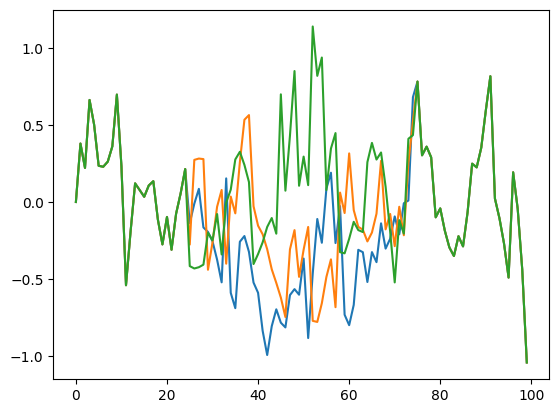

In [97]:
plt.plot(X_ou_test[0])
for i in range(0, 2):
    plt.plot(predict['imputation'][0][i])

Text(0, 0.5, 'Количество попаданий')

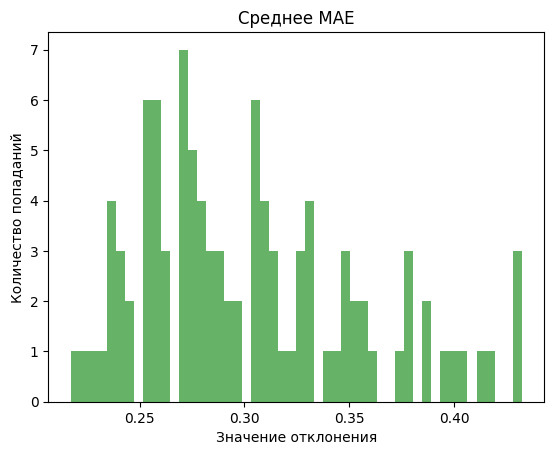

In [98]:
mistakes_normal = [Loss(X_ou_test[i, :, 0], predict['imputation'][i ,:, :, 0]) for i in range(n_test_samples)]

plt.hist(mistakes_normal, bins = 50, alpha = 0.6, color = 'g')
plt.title("Среднее MAE")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

Text(0, 0.5, 'Количество попаданий')

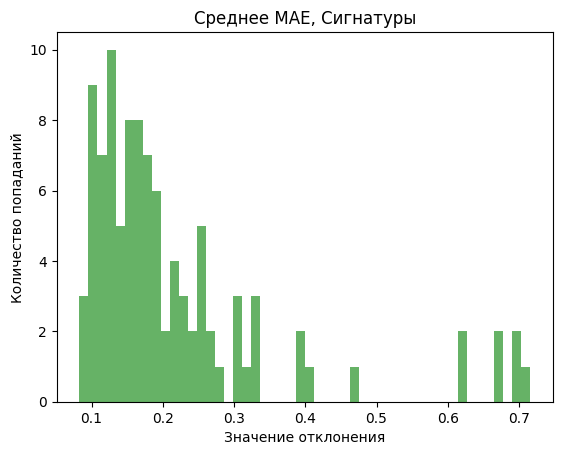

In [99]:
X_ou_test_sig = sig_data(X_ou_test, sig_level = sig_level)

mistakes_normal_sig = [Loss(X_ou_test_sig[i], predict_sig[i]) for i in range(n_test_samples)]

plt.hist(mistakes_normal_sig, bins = 50, alpha = 0.6, color = 'g')
plt.title("Среднее MAE, Сигнатуры")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

Орнштейн-Уленбеков:

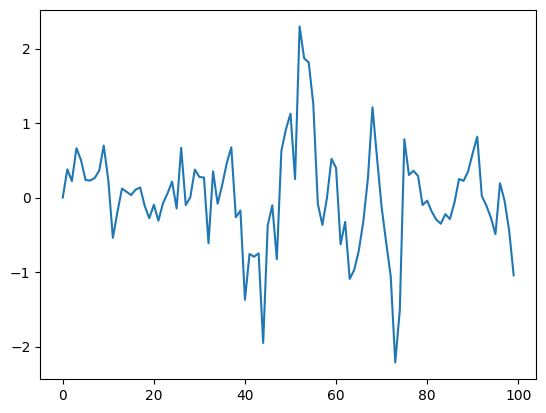

In [100]:
inject_ou_anomaly(X_ou_test, missing_start, missing_start + missing_rate - 1, mu=0, theta=0.3, sigma=0.6)

plt.plot(X_ou_test[0])

Text(0, 0.5, 'Количество попаданий')

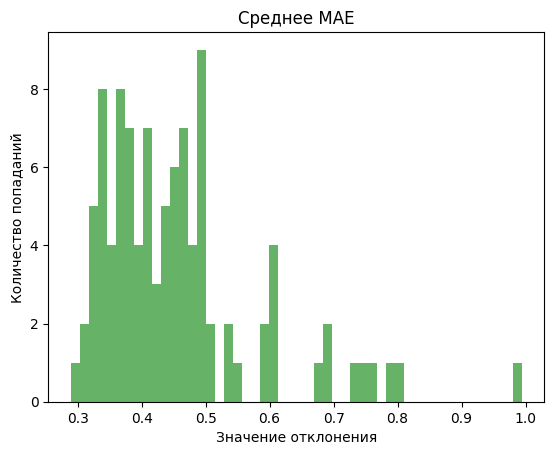

In [101]:
mistakes_ou = [Loss(X_ou_test[i, :, 0], predict['imputation'][i ,:, :, 0]) for i in range(n_test_samples)]

plt.hist(mistakes_ou, bins = 50, alpha = 0.6, color = 'g')

plt.title("Среднее MAE")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

Text(0, 0.5, 'Количество попаданий')

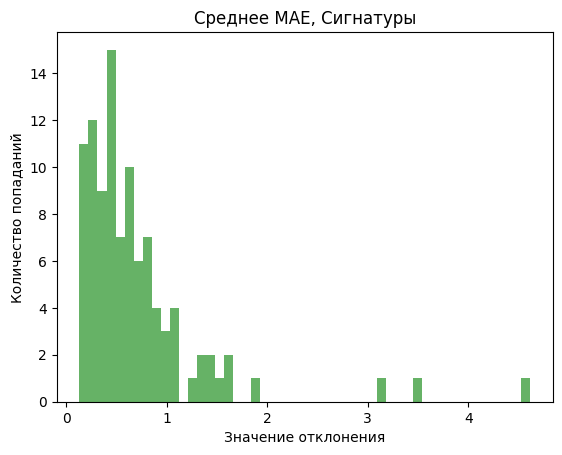

In [102]:
X_ou_an_test_sig = sig_data(X_ou_test, sig_level = sig_level)

mistakes_ou_sig = [Loss(X_ou_an_test_sig[i], predict_sig[i]) for i in range(n_test_samples)]

plt.hist(mistakes_ou_sig, bins = 50, alpha = 0.6, color = 'g')
#sns.kdeplot(mistakes, fill = True)
plt.title("Среднее MAE, Сигнатуры")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

СИНУС:

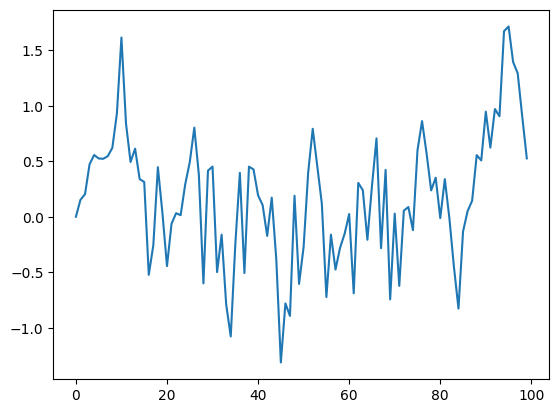

In [73]:
inject_sin_anomaly(X_ou_test, missing_start, missing_start + missing_rate - 1, periods=4, noise_rate=0.5, sin_ampl = 0.5)

plt.plot(X_ou_test[0])

Text(0, 0.5, 'Количество попаданий')

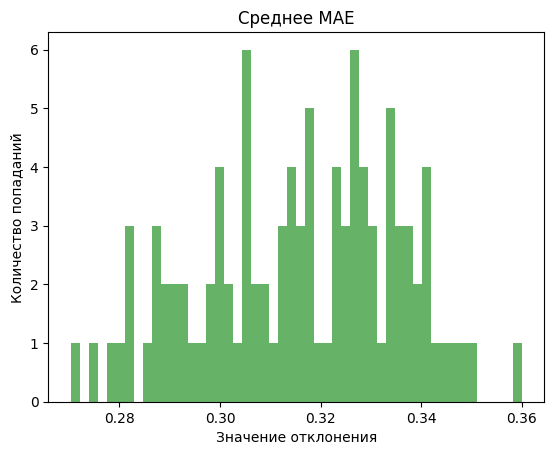

In [104]:
mistakes_sin = [Loss(X_ou_test[i, :, 0], predict['imputation'][i ,:, :, 0]) for i in range(n_test_samples)]

plt.hist(mistakes_sin, bins = 50, alpha = 0.6, color = 'g')
plt.title("Среднее MAE")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

Text(0, 0.5, 'Количество попаданий')

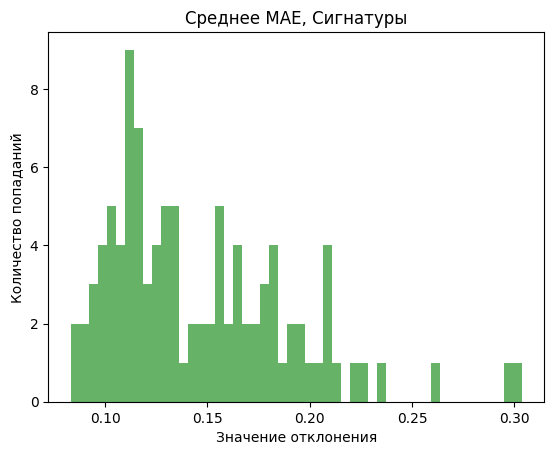

In [105]:
X_sin_an_test_sig = sig_data(X_ou_test, sig_level = sig_level)

mistakes_sin_sig = [Loss(X_sin_an_test_sig[i], predict_sig[i]) for i in range(n_test_samples)]

plt.hist(mistakes_sin_sig, bins = 50, alpha = 0.6, color = 'g')
#sns.kdeplot(mistakes, fill = True)
plt.title("Среднее MAE, Сигнатуры")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

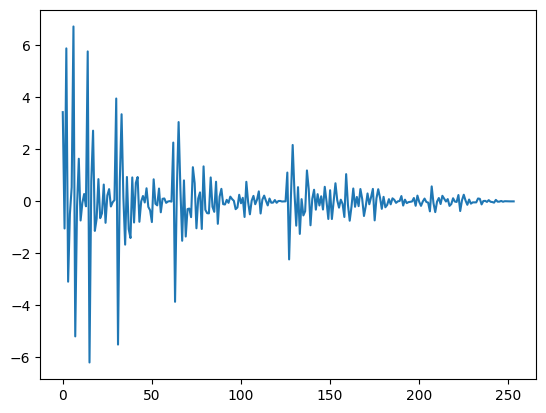

In [106]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 13))
axes = axes.flatten()

axes[0].plot(X_ou_test_sig[0])
axes[0].set_title("Нормированная сигнатура О-У без аномалий")

axes[1].plot(X_ou_an_test_sig[0])
axes[1].set_title("Нормированная сигнатура с О-У аномалией")

axes[2].plot(X_sin_an_test_sig[0])
axes[2].set_title("Нормированная сигнатура с аномалией синус")
plt.tight_layout()
plt.show()

ШУМ:

In [53]:
n_steps_noise = 100
n_samples_noise = 1000
n_test_samples_noise = 200
n_sampling_times_noise = 200
missing_rate_noise = 25
missing_start_noise = 25
sig_level_noise = 7

In [12]:
path = 'CSDI_example_2'
model2 = CSDI(
    n_steps=n_steps_noise,
    n_features=1,
    n_layers=2,
    n_heads=4,
    n_channels=64,
    d_time_embedding=16,
    d_feature_embedding=16,
    d_diffusion_embedding=16,
    is_unconditional=False,
    target_strategy="mix",
    n_diffusion_steps=100,
    schedule="linear",
    beta_start=0.001,
    beta_end=0.02,
    batch_size=32,
    epochs=100,
    #patience=10,
    # device=None, # Пусть автоматически выбирает устройство
    saving_path=path,
    model_saving_strategy="better",
    #verbose=True
)

2025-02-26 11:49:47 [INFO]: No given device, using default device: cpu
2025-02-26 11:49:47 [INFO]: Model files will be saved to CSDI_example_2/20250226_T114947
2025-02-26 11:49:47 [INFO]: Tensorboard file will be saved to CSDI_example_2/20250226_T114947/tensorboard
2025-02-26 11:49:47 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 150,001


In [13]:
X_noise_train = generate_noise(n_samples_noise, n_steps_noise, noise_rate = 1)
data2 = {"X": X_noise_train}
model2.fit(data2)

2025-02-26 11:50:43 [INFO]: Epoch 001 - training loss: 0.8155
2025-02-26 11:50:44 [INFO]: Epoch 002 - training loss: 0.7866
2025-02-26 11:50:45 [INFO]: Epoch 003 - training loss: 0.7781
2025-02-26 11:50:46 [INFO]: Epoch 004 - training loss: 0.7833
2025-02-26 11:50:47 [INFO]: Epoch 005 - training loss: 0.7607
2025-02-26 11:50:48 [INFO]: Epoch 006 - training loss: 0.7886
2025-02-26 11:50:49 [INFO]: Epoch 007 - training loss: 0.7629
2025-02-26 11:50:50 [INFO]: Epoch 008 - training loss: 0.7976
2025-02-26 11:50:51 [INFO]: Epoch 009 - training loss: 0.7840
2025-02-26 11:50:52 [INFO]: Epoch 010 - training loss: 0.7714
2025-02-26 11:50:53 [INFO]: Epoch 011 - training loss: 0.7950
2025-02-26 11:50:54 [INFO]: Epoch 012 - training loss: 0.7704
2025-02-26 11:50:55 [INFO]: Epoch 013 - training loss: 0.7673
2025-02-26 11:50:57 [INFO]: Epoch 014 - training loss: 0.7644
2025-02-26 11:50:58 [INFO]: Epoch 015 - training loss: 0.7538
2025-02-26 11:50:59 [INFO]: Epoch 016 - training loss: 0.7584
2025-02-

In [54]:
X_noise_test = generate_noise(n_test_samples_noise, n_steps_noise, noise_rate = 1)
X_noise_test_missing = introduce_missigness(X_noise_test, missing_rate_noise, missing_start_noise)
data_missing2 = {"X": X_noise_test_missing}

predict2 = model2.predict(data_missing2, n_sampling_times=n_sampling_times_noise)

In [55]:
predict_sig_noise = [sig_data(predict2['imputation'][i], sig_level = sig_level_noise) for i in range(n_test_samples_noise)]

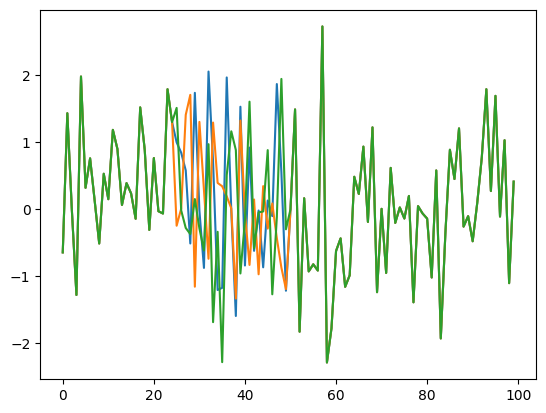

In [56]:
plt.plot(X_noise_test[0])
for i in range(0, 2):
    plt.plot(predict2['imputation'][0][i])

Text(0, 0.5, 'Количество попаданий')

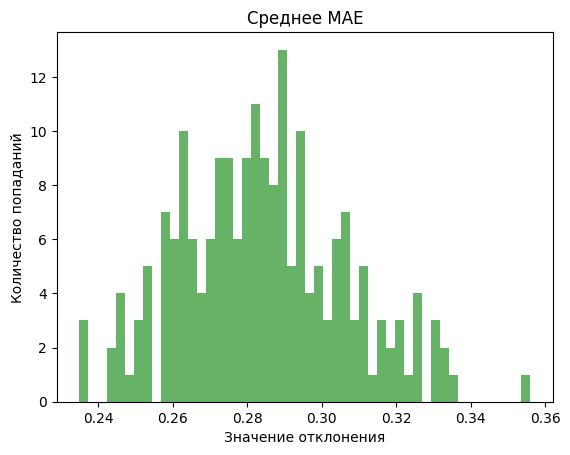

In [57]:
mistakes_normal_noise = [Loss(X_noise_test[i, :, 0], predict2['imputation'][i ,:, :, 0]) for i in range(n_test_samples_noise)]

plt.hist(mistakes_normal_noise, bins = 50, alpha = 0.6, color = 'g')
plt.title("Среднее MAE")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

Text(0, 0.5, 'Количество попаданий')

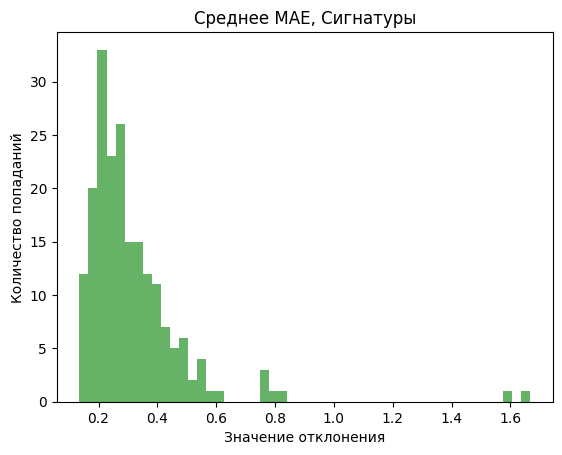

In [58]:
X_noise_test_sig = sig_data(X_noise_test, sig_level = sig_level_noise)

mistakes_normal_noise_sig = [Loss(X_noise_test_sig[i], predict_sig_noise[i]) for i in range(n_test_samples_noise)]

plt.hist(mistakes_normal_noise_sig, bins = 50, alpha = 0.6, color = 'g')
plt.title("Среднее MAE, Сигнатуры")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

ШУМ С НУЛЯМИ

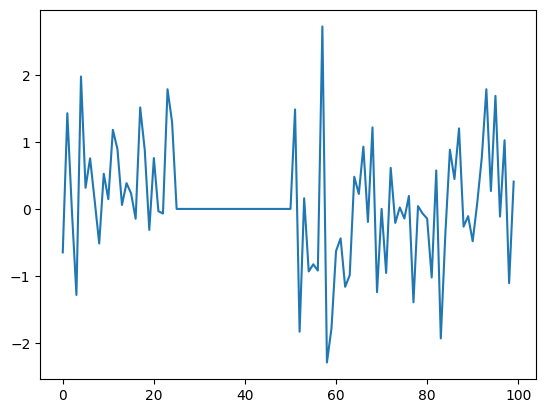

In [59]:
X_noise_test[:, missing_start_noise: missing_start_noise + missing_rate_noise, 0] = 0
plt.plot(X_noise_test[0])

Text(0, 0.5, 'Количество попаданий')

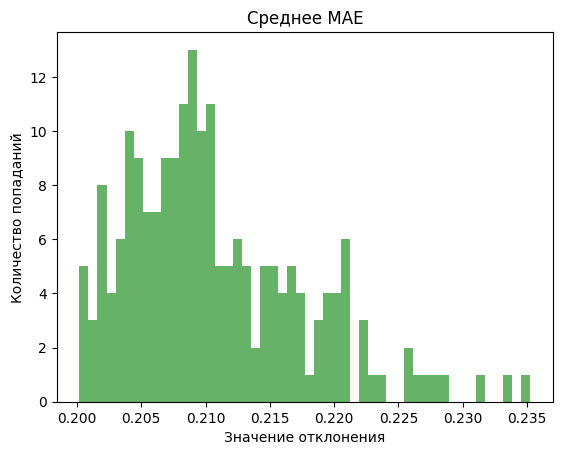

In [60]:
mistakes_zeros = [Loss(X_noise_test[i, :, 0], predict2['imputation'][i ,:, :, 0]) for i in range(n_test_samples_noise)]

plt.hist(mistakes_zeros, bins = 50, alpha = 0.6, color = 'g')

plt.title("Среднее MAE")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

Text(0, 0.5, 'Количество попаданий')

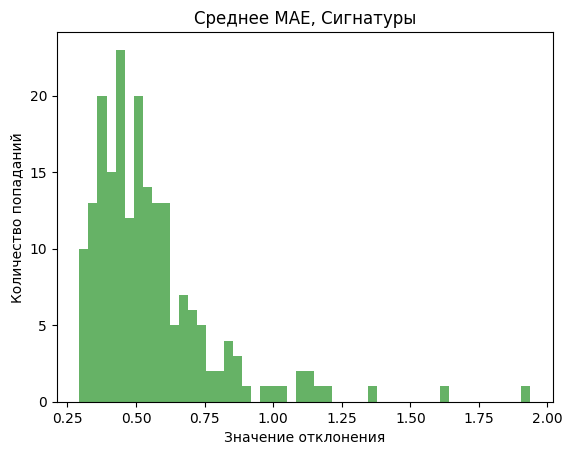

In [61]:
X_zeros_an_test_sig = sig_data(X_noise_test, sig_level = sig_level_noise)

mistakes_zeros_sig = [Loss(X_zeros_an_test_sig[i], predict_sig_noise[i]) for i in range(n_test_samples_noise)]

plt.hist(mistakes_zeros_sig, bins = 50, alpha = 0.6, color = 'g')
#sns.kdeplot(mistakes, fill = True)
plt.title("Среднее MAE, Сигнатуры")
plt.xlabel("Значение отклонения")
plt.ylabel("Количество попаданий")

In [62]:
print("Ср. ошибка: \n без аном без сиг %s \n без аном с сиг %s \n с аном без сиг %s \n с аном с сиг %s" % 
     (round(np.mean(mistakes_normal_noise), 2), round(np.mean(mistakes_normal_noise_sig), 2),
      round(np.mean(mistakes_zeros), 2), round(np.mean(mistakes_zeros_sig), 2)))

Ср. ошибка: 
 без аном без сиг 0.28 
 без аном с сиг 0.32 
 с аном без сиг 0.21 
 с аном с сиг 0.55
